<a href="https://colab.research.google.com/github/willystumblr/AI-ML_Team_5/blob/kms/nlp/NLP_DT_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
test_df = pd.read_csv("./test.csv")
train_df = pd.read_csv("./train.csv")

# Data
## What should I expect the data format to be?
Each sample in the train and test set has the following information:

* The `text` of a tweet
* A `keyword` from that tweet (although this may be blank!)
* The `location` the tweet was sent from (may also be blank)

## What am I predicting?
You are predicting whether a given tweet is about a real disaster or not. If so, predict a `1`. If not, predict a `0`.


In [ ]:
test_df.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [ ]:
train_df.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Missing values

In [ ]:
missing_val = pd.DataFrame(train_df.isnull().sum())
missing_val = missing_val.reset_index()
missing_val

,index,0
0,id,0
1,keyword,61
2,location,2533
3,text,0
4,target,0


In [ ]:
for df in [train_df, test_df]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [ ]:
missing_val = pd.DataFrame(train_df.isnull().sum())
missing_val = missing_val.reset_index()
missing_val

,index,0
0,id,0
1,keyword,0
2,location,0
3,text,0
4,target,0


### Number of unique values

In [ ]:
unique_train_k = train_df['keyword'].nunique()
print(unique_train_k)

222


In [ ]:
unique_train_l = train_df["location"].nunique()
unique_train_l

3342

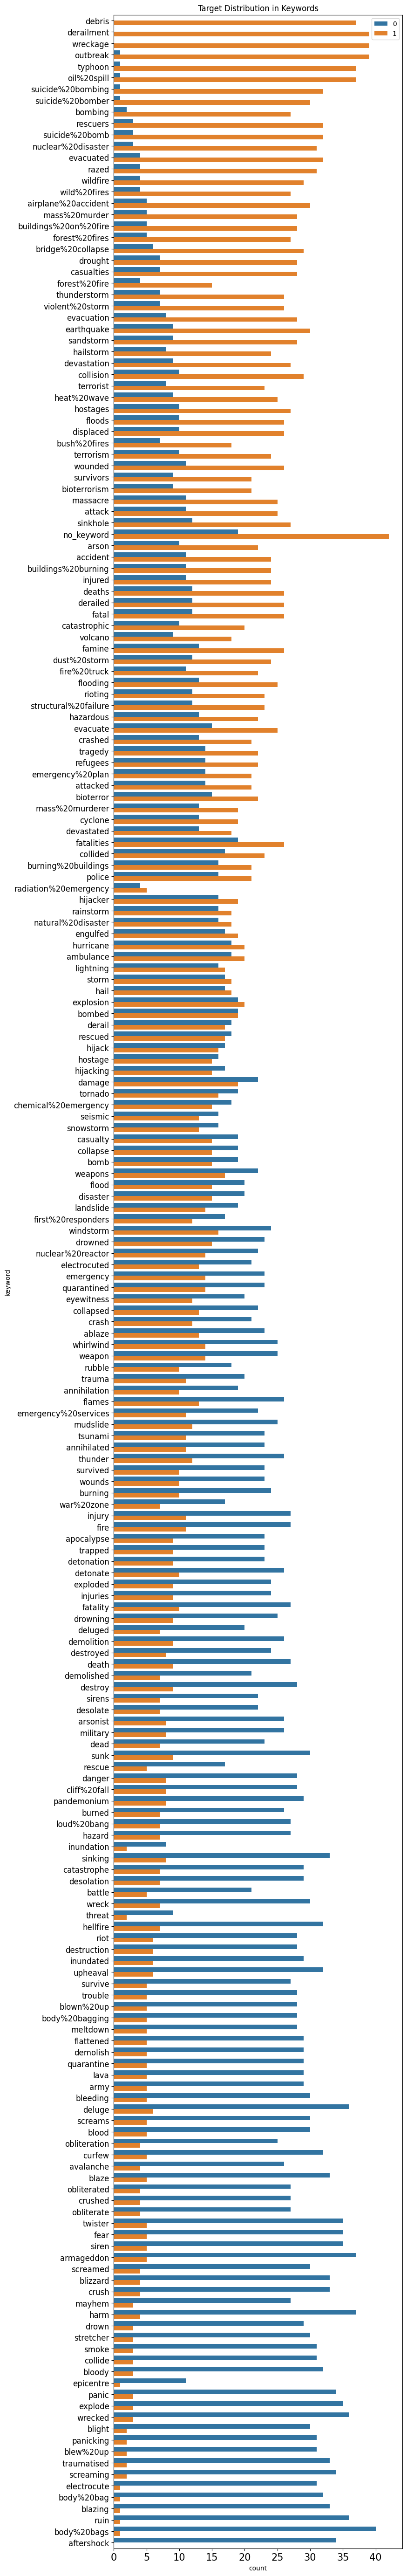

In [ ]:
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train_df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train_df.drop(columns=['target_mean'], inplace=True)


## Meta Features
Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. **It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies.** Non-disaster tweets **have more typos than disaster tweets because they are coming from individual users**. 

The meta features used for the analysis are;

* `word_count`: number of words in text
* `url_count`: number of urls in text
* `mean_word_length`: average character count in words
* `char_count`: number of characters in text
* `punctuation_count`: number of punctuations in text
* `hashtag_count`: number of hashtags (#) in text
* `mention_count`: number of mentions (@) in text

In [ ]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

import tokenize

In [ ]:
import math, os, re, time, random, string

In [ ]:
# word_count
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# url_count
train_df['url_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_df['url_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))

# punctuation_count
train_df['punctuation_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))



### Stopwords
Stopwords are the words in any language which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For some search engines, these are some of the most common, short function words, such as the, is, at, which, and on. In this case, stop words can cause problems when searching for phrases that include them, particularly in names such as “The Who” or “Take That”.

There is no hard and fast rule on when to remove stop words. **But I would suggest removing stop words if our task to be performed is one of Language Classification, Spam Filtering, Caption Generation, Auto-Tag Generation, Sentiment analysis, or something that is related to text classification.**

**Pros and Cons:**

One of the first things that we ask ourselves is what are the pros and cons of any task we perform. Let’s look at some of the pros and cons of stop word removal in NLP.


**pros:**
* Stop words are often removed from the text before training deep learning and machine learning models since stop words occur in abundance, hence providing little to no unique information that can be used for classification or clustering.
* On removing stopwords, dataset size decreases, and the time to train the model also decreases without a huge impact on the accuracy of the model.
* Stopword removal can potentially help in improving performance, as there are fewer and only significant tokens left. Thus, the classification accuracy could be improved


**cons:**
Improper selection and removal of stop words can change the meaning of our text. So we have to be careful in choosing our stop words.

In [ ]:
from wordcloud import STOPWORDS

# stop_word_count
train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))